In [155]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import xgboost as xgb
import time

### Importing pre-processed data

We'll start by importing our pre-processed data from the previous notebook.

In [156]:
X_train = pd.read_csv('..\data\X_train.csv').values
X_test = pd.read_csv('..\data\X_test.csv').values
y_train = pd.read_csv('..\data\y_train.csv').values
y_test = pd.read_csv('..\data\y_test.csv').values

In [157]:
print('X_train shape:', X_train.shape, '\nX_test shape:', X_test.shape)
print('\ny_train shape:', y_train.shape, '\ny_test shape:', y_test.shape)

X_train shape: (34189, 53) 
X_test shape: (14653, 53)

y_train shape: (34189, 1) 
y_test shape: (14653, 1)


In [158]:
# Reshaping y sets for models, they need to be 1d arrays
y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)
print('y_train shape:', y_train.shape, '\ny_test shape:', y_test.shape)

y_train shape: (34189,) 
y_test shape: (14653,)


####  We'll build 3 different models and tune hyperparameters using Random Search and cross validation. We'll use AUC as metric to compare performance between the models.

- Logistic Regression
- Random Forest
- XGB

## Logistic Regression

In [159]:
param_lr = {'C':[.001, .01, .1, 1, 10, 100],
            'solver':['lbfgs','saga'],
           'max_iter':[1200]}

In [160]:
lr = LogisticRegression()

In [161]:
lr_clf = RandomizedSearchCV(lr, param_distributions=param_lr, cv=5, scoring='roc_auc', n_jobs=-1, random_state=42)

In [162]:
start = time.time()
lr_model = lr_clf.fit(X_train, y_train)
end = time.time()
print('Training time:', round(end - start,), 'seconds')

Training time: 70.74672937393188


In [163]:
print(lr_model.best_params_)
print(lr_model.best_score_)

{'solver': 'lbfgs', 'max_iter': 1200, 'C': 100}
0.9077122983178102


Now that we've made a first pass on hyperparameters, we can try to further tune around those hyperparameters and see if we can improve the model's preformance.

In [164]:
param_lr_2 = {'C':[50, 100, 200],
            'solver':['lbfgs','saga'],
           'max_iter':[1200]}

In [165]:
lr_clf = RandomizedSearchCV(lr, param_distributions=param_lr_2, cv=5, scoring='roc_auc', n_jobs=-1, random_state=42)

In [166]:
start = time.time()
lr_model_2 = lr_clf.fit(X_train, y_train)
end = time.time()
print('Training time:', round(end - start,), 'seconds')

C:\Users\jodur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Training time: 99.21132755279541


In [167]:
print(lr_model_2.best_params_)
print(lr_model_2.best_score_)

{'solver': 'lbfgs', 'max_iter': 1200, 'C': 200}
0.9077153771261912


We see it only raised the C value, but the performance was the same.

#### LogReg - Tuned model

In [168]:
lr_tuned = LogisticRegression(solver='lbfgs', max_iter=1000, C=100, random_state=42)
lr_tuned.fit(X_train, y_train)

LogisticRegression(C=100, max_iter=1000, random_state=42)

In [169]:
y_pred_lr = lr_tuned.predict(X_test)
y_pred_proba_lr = lr_tuned.predict_proba(X_test)[:,1]

#### LogReg - Metrics

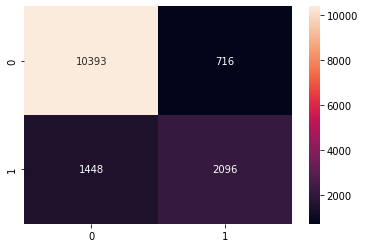

In [170]:
sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, fmt='.0f');

In [171]:
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.88      0.94      0.91     11109
           1       0.75      0.59      0.66      3544

    accuracy                           0.85     14653
   macro avg       0.81      0.76      0.78     14653
weighted avg       0.85      0.85      0.85     14653



In [172]:
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, y_pred_proba_lr)

In [173]:
auc_lr = auc(fpr_lr, tpr_lr)
auc_lr

0.9065008045659602

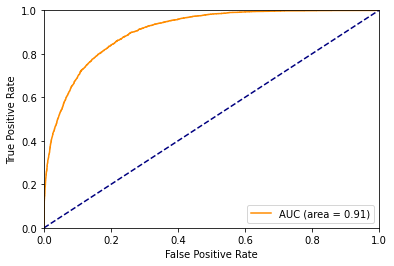

In [174]:
plt.figure()
plt.plot(fpr_lr, tpr_lr, color="darkorange",
    label="AUC (area = %0.2f)" % auc_lr)
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

### Bayes Optimizer

In [175]:
'''from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score, cross_validate'''

'from bayes_opt import BayesianOptimization\nfrom sklearn.model_selection import cross_val_score, cross_validate'

In [176]:
'''def lr_eval(C, solver, max_iter):
    params = {
        'C': C,
        'solver': solver,
        'max_iter': max_iter
    }
    
    lr = LogisticRegression()
    cv_results = cross_validate(lr, X_train, y_train, fit_params=params, cv=5, scoring='roc_auc')'''

"def lr_eval(C, solver, max_iter):\n    params = {\n        'C': C,\n        'solver': solver,\n        'max_iter': max_iter\n    }\n    \n    lr = LogisticRegression()\n    cv_results = cross_validate(lr, X_train, y_train, fit_params=params, cv=5, scoring='roc_auc')"

In [177]:
'''params = {'C': [.01, .1, 1, 10],
        'solver': ['lbfgs','saga']
    }

lr = LogisticRegression()
cv_results = cross_validate(lr, X_train, y_train, fit_params=params, cv=5, scoring='roc_auc', return_train_score=True)'''

"params = {'C': [.01, .1, 1, 10],\n        'solver': ['lbfgs','saga']\n    }\n\nlr = LogisticRegression()\ncv_results = cross_validate(lr, X_train, y_train, fit_params=params, cv=5, scoring='roc_auc', return_train_score=True)"

## Random Forest

In [178]:
param_rf = {'n_estimators':[100,300,500,700],
            'criterion':['gini','entropy'],
            'max_depth':[10,20,30],              
            'min_samples_split': [2, 4, 6],      #default = 2
            'min_samples_leaf': [1, 2, 3] }      #default = 1

In [179]:
rf = RandomForestClassifier()
rf_clf = RandomizedSearchCV(rf, param_distributions = param_rf, cv = 5, scoring = 'roc_auc', n_jobs = -1, \
                            verbose=10, random_state=42)

In [180]:
start = time.time()
rf_model = rf_clf.fit(X_train, y_train)
end = time.time()
print('Training time:', round(end - start,), 'seconds')

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Training time: 114.8535270690918


In [181]:
print(rf_model.best_params_)
print(rf_model.best_score_)

{'n_estimators': 300, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_depth': 20, 'criterion': 'entropy'}
0.9166475311328174


Running a second round of tuning

In [212]:
param_rf_2 = {'n_estimators':[300, 400, 500],
            'criterion':['gini','entropy'],
            'max_depth':[15, 20, 25, 30],              
            'min_samples_split': [5, 6, 7],      #default = 2
            'min_samples_leaf': [3, 4 ,5] }      #default = 1

In [213]:
rf_clf_2 = RandomizedSearchCV(rf, param_distributions = param_rf_2, cv = 5, scoring = 'roc_auc', n_jobs = -1, \
                              verbose=10, random_state=42)

In [214]:
start = time.time()
rf_model_2 = rf_clf_2.fit(X_train, y_train)
end = time.time()
print('Training time:', round(end - start,), 'seconds')

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Training time: 91.39031505584717


In [215]:
print(rf_model_2.best_params_)
print(rf_model_2.best_score_)

{'n_estimators': 400, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_depth': 20, 'criterion': 'entropy'}
0.91674582817644


#### RF - Tuned model

In [221]:
rf_tuned = RandomForestClassifier(n_estimators=400, criterion='entropy', min_samples_split=6,\
                                  min_samples_leaf=3, max_depth=20, random_state=42)
rf_tuned.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=20, min_samples_leaf=3,
                       min_samples_split=6, n_estimators=400, random_state=42)

In [222]:
y_pred_rf = rf_tuned.predict(X_test)
y_pred_proba_rf = rf_tuned.predict_proba(X_test)[:,1]

#### RF - Features importances

In [223]:
# Reading X_train again, but this time as a dataframe to get columns
X_cols = pd.read_csv('..\data\X_train.csv')

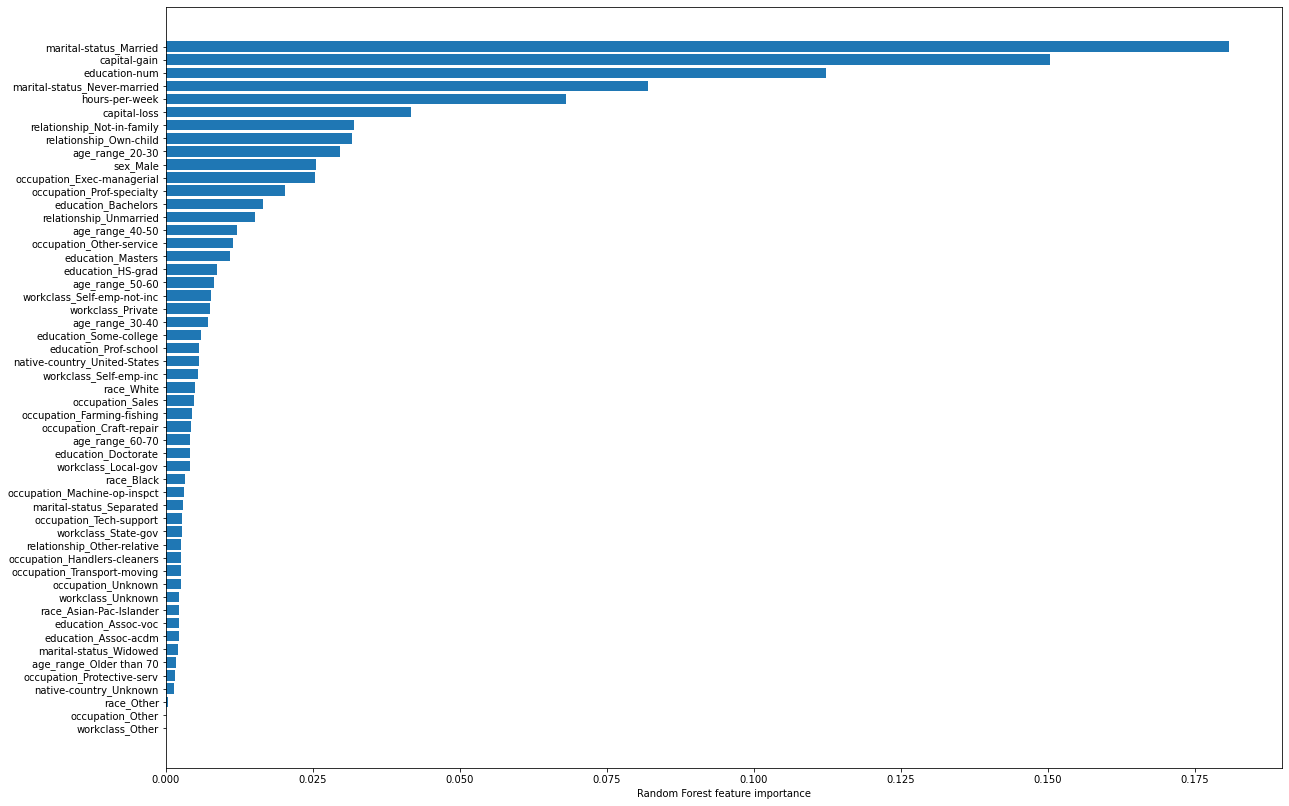

In [224]:
plt.figure(figsize=(20,14))
sorted_idx = rf_tuned.feature_importances_.argsort()
plt.barh(X_cols.columns[sorted_idx], rf_tuned.feature_importances_[sorted_idx])
plt.xlabel('Random Forest feature importance');

#### RF - Metrics

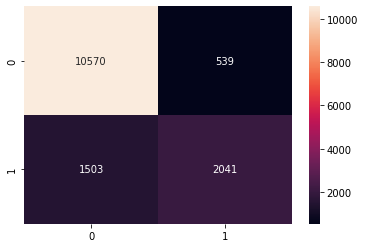

In [225]:
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='.0f');

In [226]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.88      0.95      0.91     11109
           1       0.79      0.58      0.67      3544

    accuracy                           0.86     14653
   macro avg       0.83      0.76      0.79     14653
weighted avg       0.86      0.86      0.85     14653



In [227]:
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_proba_rf)

In [228]:
auc_rf = auc(fpr_rf, tpr_rf)
auc_rf

0.913677230163573

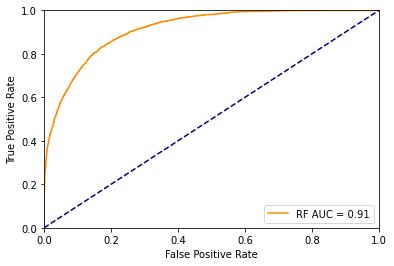

In [229]:
plt.figure()
plt.plot(fpr_rf, tpr_rf, color="darkorange",
    label="RF AUC = %0.2f" % auc_rf)
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

## XGBoost

In [195]:
dmatrix = xgb.DMatrix(data=X_train, label=y_train)

In [196]:
params_xg = {'objective':'binary:logistic','max_depth':6, 'learning_rate':0.3, 'random_state': 42}

In [197]:
start = time.time()
cv_results = xgb.cv(dtrain=dmatrix, params=params_xg, nfold=5,\
                    metrics = 'auc', num_boost_round=200, as_pandas=True)
end = time.time()
print('Training time:', round(end - start,), 'seconds')

Training time: 22.904305696487427


In [198]:
print(cv_results.tail(10))

     train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
190        0.958968       0.000557       0.924690      0.003236
191        0.959083       0.000555       0.924646      0.003226
192        0.959164       0.000607       0.924627      0.003217
193        0.959239       0.000606       0.924601      0.003205
194        0.959327       0.000587       0.924570      0.003173
195        0.959370       0.000563       0.924550      0.003157
196        0.959406       0.000557       0.924529      0.003140
197        0.959460       0.000536       0.924512      0.003127
198        0.959540       0.000545       0.924487      0.003173
199        0.959623       0.000524       0.924447      0.003142


In [199]:
test = pd.DataFrame({'Iterations':range(1,201),'Train AUC':cv_results['train-auc-mean'], \
                    'Test AUC':cv_results['test-auc-mean']})
test.head()

,Iterations,Train AUC,Test AUC
0,1,0.895727,0.892211
1,2,0.905169,0.901717
2,3,0.908198,0.904364
3,4,0.910200,0.905816
4,5,0.913204,0.907940


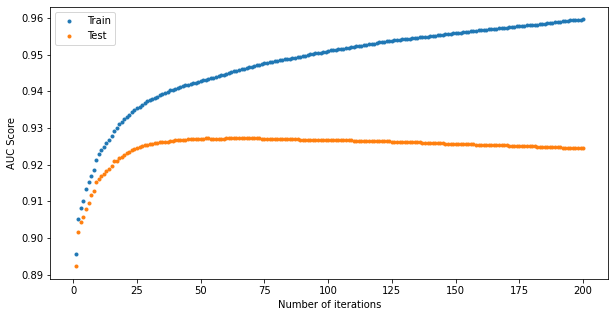

In [200]:
plt.figure(figsize=(10,5))
plt.scatter(test['Iterations'], test['Train AUC'], marker='.', label='Train')
plt.scatter(test['Iterations'], test['Test AUC'], marker='.', label='Test')
plt.legend()
plt.xlabel('Number of iterations')
plt.ylabel('AUC Score');

#### XGBoost - Tuned model

In [201]:
xgb_cl = xgb.XGBClassifier(objective='binary:logistic', n_estimators=70, seed=123, eval_metric='auc',\
                           max_depth=6, random_state=42)

In [202]:
xgb_cl.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=70, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, ...)

In [203]:
y_pred_xg = xgb_cl.predict(X_test)
y_pred_proba_xg = xgb_cl.predict_proba(X_test)[:,1]

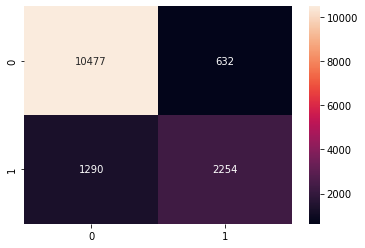

In [204]:
sns.heatmap(confusion_matrix(y_test, y_pred_xg), annot=True, fmt='.0f');

In [205]:
print(classification_report(y_test, y_pred_xg))

              precision    recall  f1-score   support

           0       0.89      0.94      0.92     11109
           1       0.78      0.64      0.70      3544

    accuracy                           0.87     14653
   macro avg       0.84      0.79      0.81     14653
weighted avg       0.86      0.87      0.86     14653



In [206]:
fpr_xg, tpr_xg, thresholds_xg = roc_curve(y_test, y_pred_proba_xg)
auc_xg = auc(fpr_xg, tpr_xg)
auc_xg

0.9240924680881241

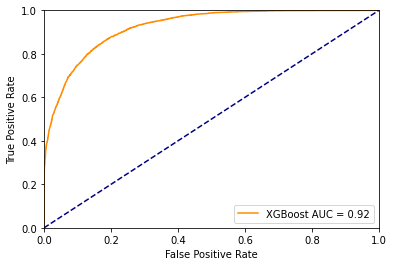

In [207]:
plt.figure()
plt.plot(fpr_xg, tpr_xg, color="darkorange",
    label="XGBoost AUC = %0.2f" % auc_xg)
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

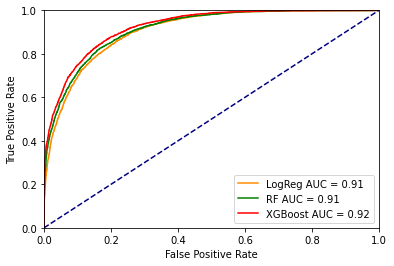

In [208]:
plt.figure()
plt.plot(fpr_lr, tpr_lr, color="darkorange",
    label="LogReg AUC = %0.2f" % auc_lr)
plt.plot(fpr_rf, tpr_rf, color="green",
    label="RF AUC = %0.2f" % auc_rf)
plt.plot(fpr_xg, tpr_xg, color="red",
    label="XGBoost AUC = %0.2f" % auc_xg)
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

## Results / Conclusions

In [ ]:
# put results on a table, talk about the experience with the models